# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw08_boosting_clustering/ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(['salary', 'salary_in_usd'], axis=1)
y = df['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

ohe = OneHotEncoder(handle_unknown="ignore")
ohe_model = ohe.fit(X_train[categorical_features])
X_train_encoded_df = pd.DataFrame(ohe_model.transform(X_train[categorical_features]).toarray(),
                                  columns=ohe.get_feature_names_out(categorical_features), index=X_train.index)
X_train_encoded_df = X_train_encoded_df.join(X_train[['work_year','remote_ratio']])


X_test_encoded_df = pd.DataFrame(ohe_model.transform(X_test[categorical_features]).toarray(),
                                  columns=ohe.get_feature_names_out(categorical_features), index=X_test.index)
X_test_encoded_df = X_test_encoded_df.join(X_test[['work_year','remote_ratio']])

X_val_encoded_df = pd.DataFrame(ohe_model.transform(X_val[categorical_features]).toarray(),
                                  columns=ohe.get_feature_names_out(categorical_features), index=X_val.index)
X_val_encoded_df = X_val_encoded_df.join(X_val[['work_year','remote_ratio']])

lr = LinearRegression().fit(X_train_encoded_df, y_train)
rmse_ = sqrt(mean_squared_error(y_test, lr.predict(X_test_encoded_df)))
mape_ = mean_absolute_percentage_error(y_test, lr.predict(X_test_encoded_df))
print('MAPE test: ', mape_)
print('RMSE test: ', rmse_)

MAPE test:  56247079.7390428
RMSE test:  30550454845545.035


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [30]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time

params = {
    'max_depth' : range(2, 10, 2),
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators' : [100, 150, 200, 250],
    'gamma' : [0, 0.1, 0.05],
    'reg_lambda': [0.1, 0.05]
}

reg = XGBRegressor(random_state= 0)

reg_hyper = GridSearchCV(estimator=reg,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=0)

start_time = time.time()
reg_hyper.fit(X_train_encoded_df, y_train)
end_time = time.time()
time_train = end_time - start_time

reg_best = reg_hyper.best_estimator_

start_time = time.time()
predict_val = reg_best.predict(X_val_encoded_df)
end_time = time.time()
time_pred = end_time - start_time

In [31]:
print('Лучшие параметры:', reg_hyper.best_params_)
print('Время обучения:', time_train)
print('Время предсказания:', time_pred)
print('MAPE: ', mean_absolute_percentage_error(y_val, predict_val))
print('RMSE: ', sqrt(mean_squared_error(y_val, predict_val)))

Лучшие параметры: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150, 'reg_lambda': 0.05}
Время обучения: 1226.7097902297974
Время предсказания: 0.029326438903808594
MAPE:  0.36616163067351615
RMSE:  52857.12040868817


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [5]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.3 MB/s eta 0:00:00


In [32]:
from catboost import CatBoostRegressor

params_cat = {
    'depth' : range(2, 10, 2) ,
    'learning_rate' : [0.01, 0.05, 0.1] ,
    'iterations' : [100, 150, 200, 250],
    'reg_lambda': [0.1, 0.05]
}

reg_cat = CatBoostRegressor(random_state= 0)

reg_hyper_cat = GridSearchCV(estimator=reg_cat,
                   param_grid=params_cat,
                   scoring='neg_mean_squared_error',
                   verbose=1)

start_time = time.time()
reg_hyper_cat.fit(X_train_encoded_df, y_train)
end_time = time.time()
time_train_cat = end_time - start_time

reg_best_cat = reg_hyper_cat.best_estimator_

start_time = time.time()
predict_val_cat = reg_best_cat.predict(X_val_encoded_df)
end_time = time.time()
time_pred_cat = end_time - start_time

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 60967.2086868	total: 2.9ms	remaining: 721ms
1:	learn: 60030.3306360	total: 5.43ms	remaining: 674ms
2:	learn: 59055.0150702	total: 7.79ms	remaining: 642ms
3:	learn: 58117.4700410	total: 10.3ms	remaining: 633ms
4:	learn: 57279.7264511	total: 12.8ms	remaining: 626ms
5:	learn: 56483.8409937	total: 15.4ms	remaining: 625ms
6:	learn: 55784.6431591	total: 17.9ms	remaining: 620ms
7:	learn: 55094.3678936	total: 20.5ms	remaining: 620ms
8:	learn: 54425.5876625	total: 23.1ms	remaining: 619ms
9:	learn: 53838.2290029	total: 25.7ms	remaining: 618ms
10:	learn: 53361.0490417	total: 28.3ms	remaining: 614ms
11:	learn: 52879.8706265	total: 30.7ms	remaining: 610ms
12:	learn: 52453.4981512	total: 33.2ms	remaining: 606ms
13:	learn: 52016.8847813	total: 35.7ms	remaining: 602ms
14:	learn: 51590.6995500	total: 38.6ms	remaining: 605ms
15:	learn: 51276.8312550	total: 41.2ms	remaining: 602ms
16:	learn: 51037.2830025	total: 43.7ms	remainin

In [33]:
print('Лучшие параметры:', reg_hyper_cat.best_params_)
print('Время обучения:', time_train_cat)
print('Время предсказания:', time_pred_cat)
print('MAPE: ', mean_absolute_percentage_error(y_val, predict_val_cat))
print('RMSE: ', sqrt(mean_squared_error(y_val, predict_val_cat)))

Лучшие параметры: {'depth': 4, 'iterations': 250, 'learning_rate': 0.1, 'reg_lambda': 0.1}
Время обучения: 251.44667077064514
Время предсказания: 0.008038043975830078
MAPE:  0.3495559558961031
RMSE:  51680.42774244808


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [34]:
from catboost import Pool

params_cat_pool = {
    'depth' : range(2, 10, 2) ,
    'learning_rate' : [0.01, 0.05, 0.1] ,
    'iterations' : [100, 150, 200, 250],
    'reg_lambda': [0.1, 0.05]
}

pool_train = Pool(data=X_train, label=y_train, cat_features=categorical_features)
pool_val = Pool(data=X_val, label=y_val, cat_features=categorical_features)

reg_cat_pool = CatBoostRegressor(random_state= 0)

reg_hyper_cat_pool = GridSearchCV(estimator=reg_cat_pool,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=0)


start_time = time.time()
reg_hyper_cat_pool = reg_cat_pool.grid_search(params_cat_pool, pool_train, cv = 3, verbose=0)
end_time = time.time()
time_train_cat_pool = end_time - start_time

reg_best_cat_pool_param = reg_hyper_cat_pool['params']
reg_best_cat_pool = CatBoostRegressor(**reg_best_cat_pool_param, random_state=0, verbose=0)
reg_best_cat_pool.fit(pool_train)

start_time = time.time()
predict_val_cat_pool = reg_best_cat_pool.predict(pool_val)
end_time = time.time()
time_pred_cat_pool = end_time - start_time

Выходные данные были обрезаны до нескольких последних строк (5000).
61:	learn: 93880.0922810	test: 89201.2440514	best: 89201.2440514 (61)	total: 227ms	remaining: 139ms
62:	learn: 93221.0600158	test: 88565.3441169	best: 88565.3441169 (62)	total: 230ms	remaining: 135ms
63:	learn: 92571.5596455	test: 87941.8955414	best: 87941.8955414 (63)	total: 234ms	remaining: 132ms
64:	learn: 91921.4196184	test: 87324.9300815	best: 87324.9300815 (64)	total: 238ms	remaining: 128ms
65:	learn: 91297.3984574	test: 86710.8358527	best: 86710.8358527 (65)	total: 242ms	remaining: 125ms
66:	learn: 90682.6656431	test: 86114.3480557	best: 86114.3480557 (66)	total: 246ms	remaining: 121ms
67:	learn: 90074.7877332	test: 85525.0896759	best: 85525.0896759 (67)	total: 250ms	remaining: 118ms
68:	learn: 89462.9160154	test: 84941.0643423	best: 84941.0643423 (68)	total: 254ms	remaining: 114ms
69:	learn: 88925.8149358	test: 84416.9778449	best: 84416.9778449 (69)	total: 255ms	remaining: 109ms
70:	learn: 88398.6921530	test: 8

In [35]:
print('Лучшие параметры:', reg_best_cat_pool_param)
print('Время обучения:', time_train_cat_pool)
print('Время предсказания:', time_pred_cat_pool)
print('MAPE: ', mean_absolute_percentage_error(y_val, predict_val_cat_pool))
print('RMSE: ', sqrt(mean_squared_error(y_val, predict_val_cat_pool)))

Лучшие параметры: {'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 0.1, 'iterations': 250}
Время обучения: 101.15038919448853
Время предсказания: 0.0013430118560791016
MAPE:  0.3355398138126055
RMSE:  51407.253228857575


**Ответ:** Качество немного улучшилось, время затраченное на обучение и вычисление предсказания закметно уменьшилось.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [36]:
from lightgbm import LGBMRegressor


params_LGBM = {
    'max_depth' : range(2, 10, 2),
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators' : [100, 150, 200, 250],
    'min_child_weight' : [1, 3, 5, 7]
}

reg_LGBM = LGBMRegressor(random_state= 0)

reg_hyper_LGBM = GridSearchCV(estimator=reg_LGBM,
                   param_grid=params_LGBM,
                   scoring='neg_mean_squared_error',
                   verbose=1)

start_time = time.time()
reg_hyper_LGBM.fit(X_train_encoded_df, y_train)
end_time = time.time()
time_train_LGBM = end_time - start_time

reg_best_LGBM = reg_hyper_LGBM.best_estimator_

start_time = time.time()
predict_val_LGBM = reg_best_LGBM.predict(X_val_encoded_df)
end_time = time.time()
time_pred_LGBM = end_time - start_time

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [37]:
print('Лучшие параметры:', reg_hyper_LGBM.best_params_)
print('Время обучения:', time_train_LGBM)
print('Время предсказания:', time_pred_LGBM)
print('MAPE: ', mean_absolute_percentage_error(y_val, predict_val_LGBM))
print('RMSE: ', sqrt(mean_squared_error(y_val, predict_val_LGBM)))

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150}
Время обучения: 148.49052715301514
Время предсказания: 0.01105952262878418
MAPE:  0.34682223717926625
RMSE:  51972.01278336243


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** \begin{array}{|c|c|c|} \hline
& XGboost & Catboost & Catboost\ Pool & LightGBM \\ \hline
time\ train & 1226.709 & 251.446 & 101.15 & 148.49\\
time\ predict & 0.029 & 0.008 & 0.001 & 0.011\\
MAPE &  0.366 & 0.350 & 0.335 & 0.3468\\
RMSE & 52857 & 51680 & 51470 & 51972\\ \hline
\end{array}

Выше представлена сравнительная таблица четырех моделей. Самой лучшей по качеству и быстрой оказалась модель на основе Catboost библиотеки со встроенным методом обработки категориальных признаков. Самой медленной и вместе с тем низкого качества стала XGboost модель.
  

\begin{array}{|c|c|c|} \hline
& XGboost & Catboost & Catboost\ Pool & LightGBM \\ \hline
iterations & 150 & 250 & 250 & 150\\
depth & 6 &  4 & 4 & 4\\
learning\_rate & 0.1 & 0.1 & 0.1 & 0.05\\ \hline
\end{array}

Гиперпараметры у каждой модели отличаются, но learning_rate у 3-х из 4-х моделей = 0.1, deapth у 3 из 4 = 4.

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [108]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [109]:
ratings = ratings.drop(['user'], axis=1)
ratings = ratings.T
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [113]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
simon and garfunkel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(ratings)

KMeans(n_clusters=5, n_init=10, random_state=0)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [47]:
kmeans.labels_

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

**Ответ:** Т.к изначально мы выбрали центры кластеров максимально отдаленные друг от друга, то возможно мы попали в выбрасы. И дальнейшие шаги бесполезны, все объекты будут пренадлежать к одному кластеру.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [82]:
import numpy as np
singleton = [(ratings.index[np.where(kmeans.labels_ == i)][0]) for i in range(1, 5)]
singleton

['daft punk', 'the beatles', '보아', 'morricone']

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [89]:
print('mean "the beatles": ', ratings.loc['the beatles'].mean())
print('mean "보아": ', ratings.loc['보아'].mean())
print('mean "morricone": ', ratings.loc['morricone'].mean())
print('mean "daft punk": ', ratings.loc['daft punk'].mean())
print('mean ratings: ', ratings.mean(axis = 1).mean())

mean "the beatles":  0.01836897659205146
mean "보아":  0.0014623432024076946
mean "morricone":  0.0010067622166630532
mean "daft punk":  0.004222227721374765
mean ratings:  0.0009932


**Ответ:** У выделившихся категорий большой процент прослушивания в отличии от других музыкальных групп, в этом датасете они являются выбросами.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [114]:
from sklearn.preprocessing import normalize
name = ratings.index
ratings = normalize(ratings)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [115]:
from collections import Counter
kmeans_norm = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans_norm.fit(ratings)
Counter(kmeans_norm.labels_)

Counter({2: 227, 4: 342, 1: 132, 0: 210, 3: 89})

**Ответ** это разделение уже достаточно хорошее, разница самого большого класса '4' с самым маленьким '3'  составляет не больше 30%

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [126]:
from scipy.spatial.distance import cosine
centroids = kmeans_norm.cluster_centers_

n = 0
top = {}
for i in centroids:
  for j in range(0,len(kmeans_norm.labels_)):
    if kmeans_norm.labels_[j] == n:
      distance = np.dot(ratings[j], i) / (np.linalg.norm(ratings[j]) * np.linalg.norm(i))
      top[name[j]] = distance
  top = dict(sorted(top.items()))
  print(list(top.keys())[-10:])
  n+=1
  top.clear()

['ween', 'wire', 'yeah yeah yeahs', 'Бах Иоганн Себастьян', 'ВИВАЛЬДИ', 'Вольфганг Амадей Моцарт', 'Йrik satie', 'ШОПЕН', '群星', 'Ｂille holiday']
['tricky & dj muggs & grease', 'triple 6 mafia', 'tupak shakur', 'tйlйpopmusik', 'underworld', 'venetian snares', 'wale', 'wu-tang clan', 'zero 7', '￼beastie boys']
['tv on the radio', 'vampire weekend', 'voxtrot', 'white stripes', 'why?', 'wilco', 'wolf parade', 'yann-tiersen', 'yo la tengo', 'young, neil']
['the hush sound', 'the red jumpsuit apparatus', 'the rocket summer', 'the spill canvas', 'the starting line', 'the used', 'thrice', 'thursday', 'underoath', '|avenged sevenfold']
['yes', 'zimmer', '\u200clinkin park', 'エイミー・ワインハウス', 'マイケル・ジャクソン', 'ルートヴィヒ・ヴァン・ベートーヴェン', '日dir en grey', '植松伸夫', '보아', '\ufeffsarah mclachlan']


**Ответ:**

1 класс: композиторы, класическая музыка

2 класс: рэп, хип-хоп

3 и 4 классы: рок

5 класс: классика и мировые хиты

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

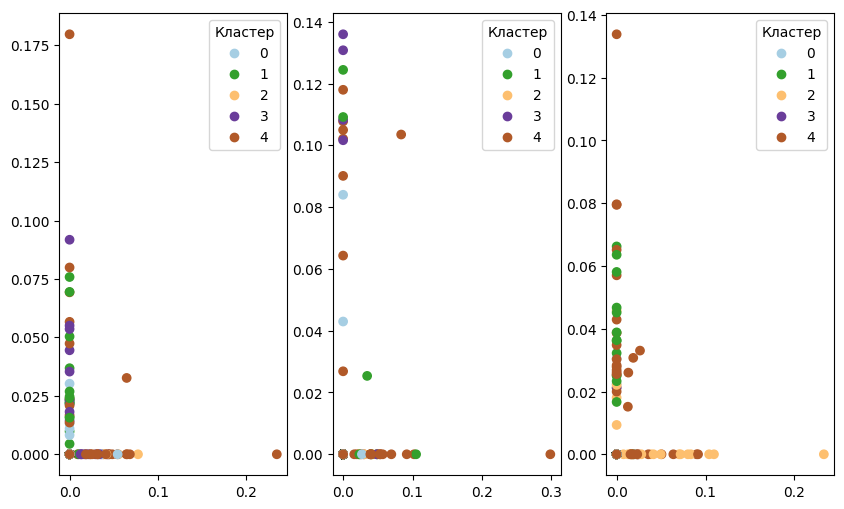

In [149]:
import matplotlib.pyplot as plt

y_pred = kmeans_norm.predict(ratings)

plt.figure(figsize = (10,6))
plt.subplot(1, 3, 1)
graph = plt.scatter(ratings[:, 100], ratings[:, 200], c=y_pred, cmap = 'Paired')
plt.legend(*graph.legend_elements(), title="Кластер")

plt.subplot(1, 3, 2)
graph = plt.scatter(ratings[:, 500], ratings[:, 600], c=y_pred, cmap = 'Paired')
plt.legend(*graph.legend_elements(), title="Кластер")

plt.subplot(1, 3, 3)
graph = plt.scatter(ratings[:, 900], ratings[:, 0], c=y_pred, cmap = 'Paired')
plt.legend(*graph.legend_elements(), title="Кластер")

**Ответ:** По данной визуализации нельзя ничего сказать о кластерах, т.к. мы используем всего лишь два признака(доли прослушиваний двух человек - большинство объектов просто имеют долю 0)

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

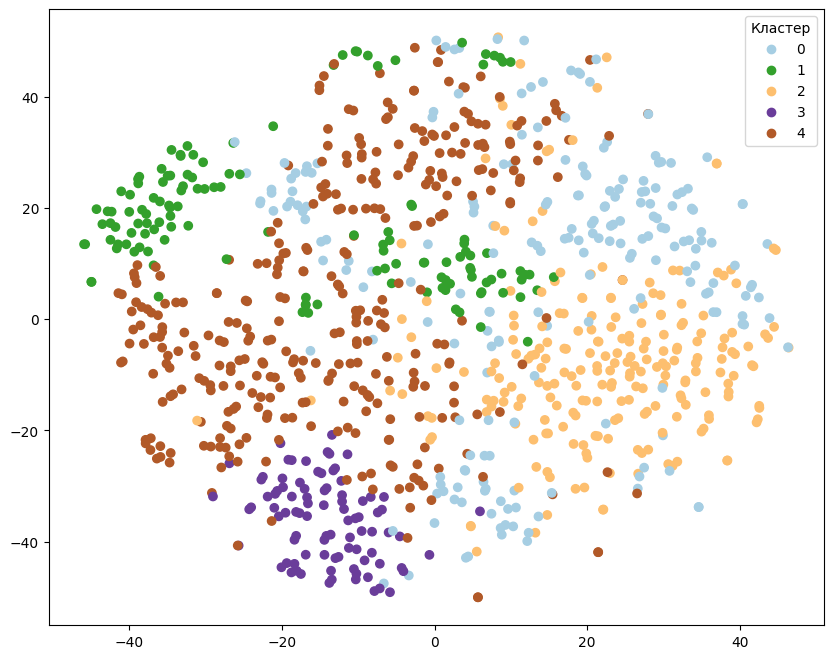

In [155]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_ = tsne.fit_transform(ratings)

plt.figure(figsize=(10, 8))
graph = plt.scatter(tsne_[:, 0], tsne_[:, 1], c=y_pred, cmap='Paired')
plt.legend(*graph.legend_elements(), title="Кластер")

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [156]:
from sklearn.metrics import silhouette_score

silhouette_ = []

for i in range(2, 101):
    kmeans = KMeans(n_clusters=i, random_state=42)
    silhouette = silhouette_score(ratings, kmeans.fit_predict(ratings))
    silhouette_.append(silhouette)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

NameError: name 'range_n_clusters' is not defined

In [158]:
n_best = range(2,101)[np.argmax(silhouette_)]
print('Оптимальное количество кластеров', n_best)

Оптимальное количество кластеров 95


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [159]:
kmeans_norm = KMeans(n_clusters = 95, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans_norm.fit(ratings)
centroids = kmeans_norm.cluster_centers_

n = 0
top = {}
for i in centroids:
  for j in range(0,len(kmeans_norm.labels_)):
    if kmeans_norm.labels_[j] == n:
      distance = np.dot(ratings[j], i) / (np.linalg.norm(ratings[j]) * np.linalg.norm(i))
      top[name[j]] = distance
  top = dict(sorted(top.items()))
  print(list(top.keys())[-10:])
  n+=1
  top.clear()

['eagles of death metal', 'muse', 'the killers']
['alanis morrisette', 'ben folds', 'ben folds five', 'berenaked ladies', 'counting crows', 'direr straits', 'līve', 'matchbox twenty', 'train']
['cocorosie', 'feist', 'fiest', 'm. ward', 'pj harvey', 'sleater-kinney', 'sparklehorse', 'sun kil moon', 'the raconteurs', 'thhe raveonettes']
['daphne loves derby', 'four year strong', 'good charlotte', 'mxpx', 'new found glory', 'owl city', 'set your goals', 'sugarcult', 'the ataris', 'the starting line']
['my chemicall romance', 'rise against', 'scary kids scaring kids', 'secondhand serenade', 'senses fail*', 'silverstein', 'sum41', 'the prodigy', 'the red jumpsuit apparatus', 'the used']
['rice, demien', 'rogue wave', 'rufus wainwright', 'sufjan stevens', 'the arcade fire', 'the decemberists', 'the national', 'the new pornographers', 'the streets', 'they might be giants [tmbg]']
['sunset rubdown', 'the american analog set', 'the books', 'the dodos', 'the fiery furnaces', 'the microphones', '

**Ответ:** # классы стали точнее определять жанр музыки, 0 класс - металл, 14 класс- панк.

Сделайте t-SNE визуализацию полученной кластеризации.

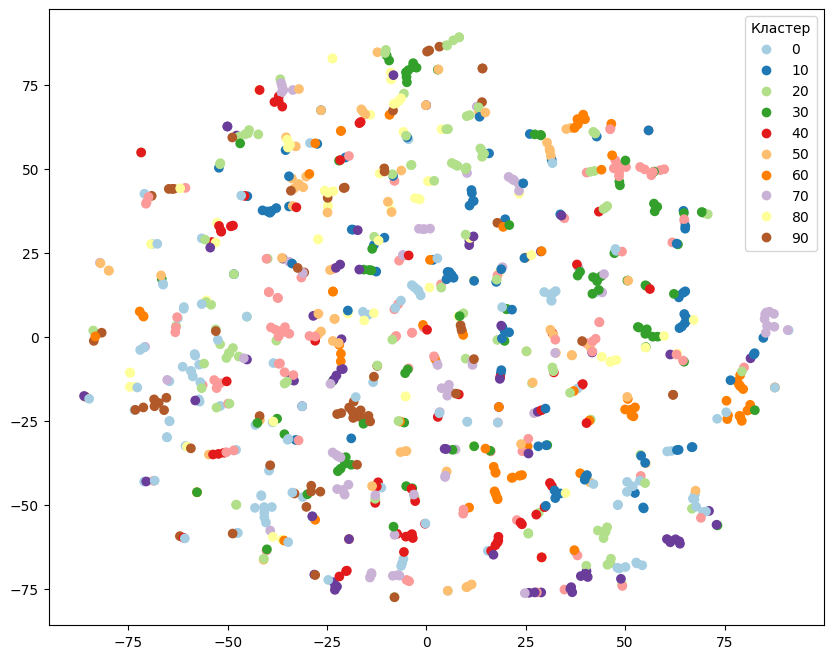

In [161]:
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
tsne_ = tsne.fit_transform(ratings)
y_pred = kmeans_norm.predict(ratings)
plt.figure(figsize=(10, 8))
graph = plt.scatter(tsne_[:, 0], tsne_[:, 1], c=y_pred, cmap='Paired')
plt.legend(*graph.legend_elements(), title="Кластер")

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

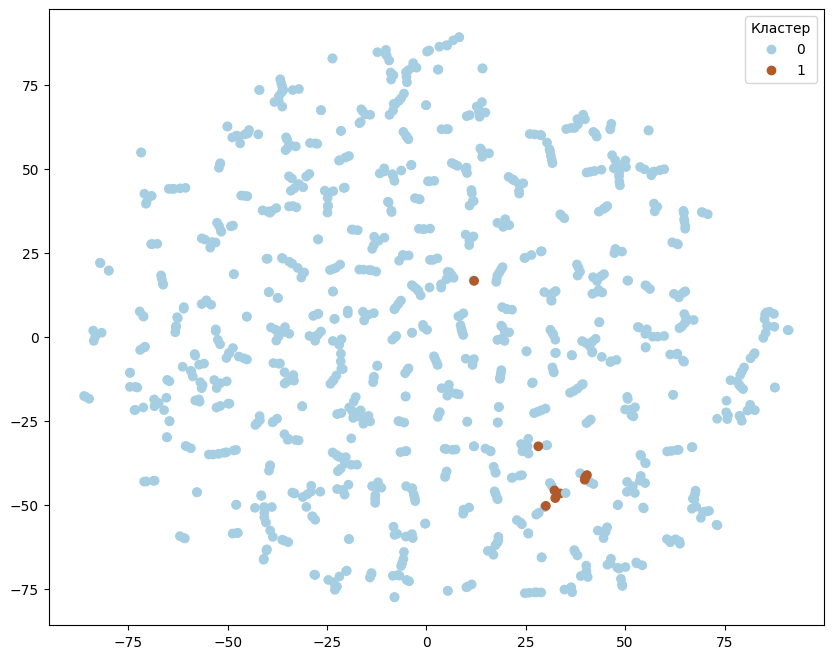

In [171]:
plt.figure(figsize=(10, 8))
graph = plt.scatter(tsne_[:, 0], tsne_[:, 1], c=(y_pred==14), cmap='Paired')
plt.legend(*graph.legend_elements(), title="Кластер")

**Ответ:** Да, объекты стоят близко, есть выброс, но возможно это из-за уменьшении размерности.